Instructions:
1. Choose a unique dataset from: https://archive.ics.uci.edu
2. Your dataset should be unique from your classmates otherwise no points will be given for this exercise.
### Complete the Tasks in bold

## Data Exploration

**TASK: Create a correlation heatmap.**

**TASK: What are the top 5 correlated frequencies with the target\label?**

*Note: You many need to map the label to 0s and 1s.*

*Additional Note: We're looking for **absolute** correlation values.*

Index(['SEQN', 'age_group', 'RIDAGEYR', 'RIAGENDR', 'PAQ605', 'BMXBMI',
       'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN'],
      dtype='object')
      SEQN  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0  73564.0      61.0       2.0     2.0    35.7   110.0     2.0   150.0  14.91
1  73568.0      26.0       2.0     2.0    20.3    89.0     2.0    80.0   3.85
2  73576.0      16.0       1.0     2.0    23.2    89.0     2.0    68.0   6.14
3  73577.0      32.0       1.0     2.0    28.9   104.0     2.0    84.0  16.15
4  73580.0      38.0       2.0     1.0    35.9   103.0     2.0    81.0  10.92


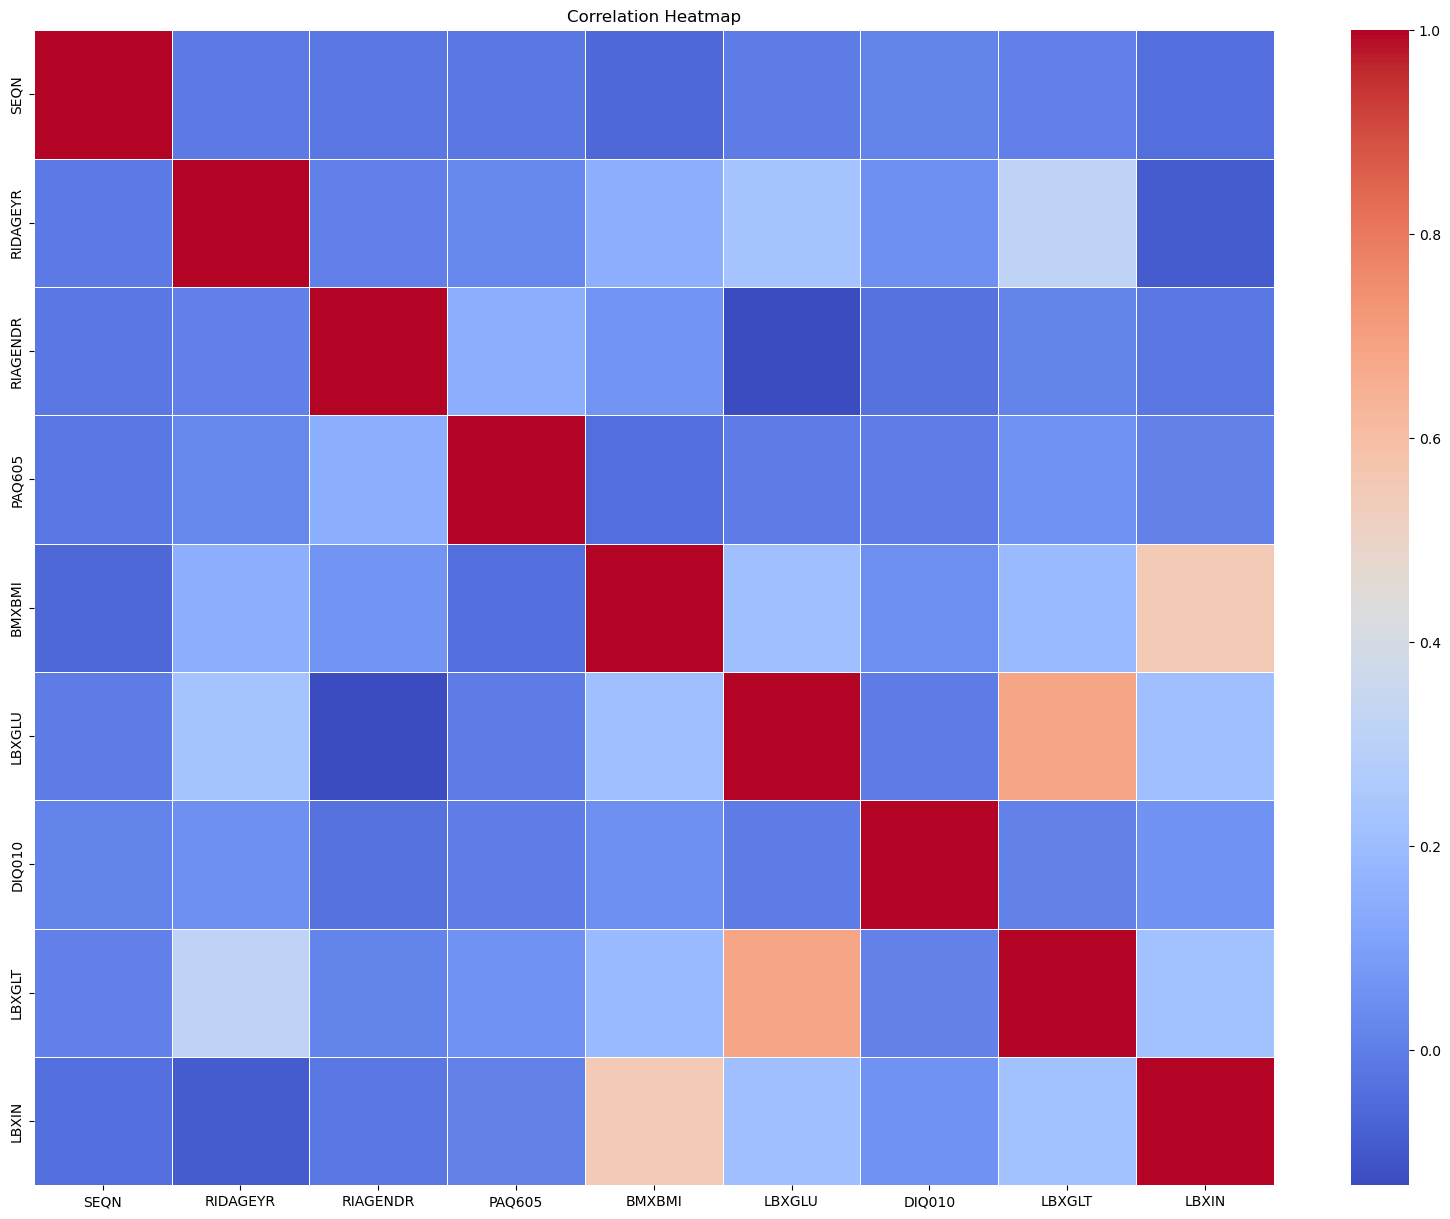

Top 5 correlated features with the target label:
 ['LBXGLT', 'LBXGLU', 'BMXBMI', 'LBXIN', 'DIQ010']


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset from the local file
file_path = 'NHANES_age_prediction.csv'
df = pd.read_csv(file_path)

# Display the column names to find the target label column
print(df.columns)

# Convert non-numeric columns to numeric where appropriate or drop them
df = df.apply(pd.to_numeric, errors='coerce')

# Drop columns with all NaN values resulting from non-numeric conversion
df.dropna(axis=1, how='all', inplace=True)

# Drop rows with any NaN values
df.dropna(inplace=True)

# Display the first few rows of the dataframe
print(df.head())

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Assuming the target label column is named 'RIDAGEYR'
target_col = 'RIDAGEYR'

# Compute the absolute correlations with the target label
absolute_corr = corr_matrix[target_col].abs()

# Drop the target label from the correlations
absolute_corr = absolute_corr.drop(target_col)

# Get the top 5 correlated features
top_5_corr = absolute_corr.sort_values(ascending=False).head(5)
print("Top 5 correlated features with the target label:\n", top_5_corr.index.tolist())



## Train | Test Split

Our approach here will be one of using Cross Validation on 90% of the dataset, and then judging our results on a final test set of 10% to evaluate our model.

**TASK: Split the data into features and labels, and then split into a training set and test set, with 90% for Cross-Validation training, and 10% for a final test set.**

*Note: Do not forget to put a random_state for reproducibility.*

**TASK: Create a PipeLine that contains both a StandardScaler and a KNN model**

**TASK: Perform a grid-search with the pipeline to test various values of k and report back the best performing parameters.**

**(HARD) TASK: Using the .cv_results_ dictionary, see if you can create a plot of the mean test scores per K value.**

### Final Model Evaluation

**TASK: Using the grid classifier object from the previous step, get a final performance classification report and confusion matrix.**

Index(['SEQN', 'age_group', 'RIDAGEYR', 'RIAGENDR', 'PAQ605', 'BMXBMI',
       'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN'],
      dtype='object')
Best parameters found:  {'knn__n_neighbors': 11}


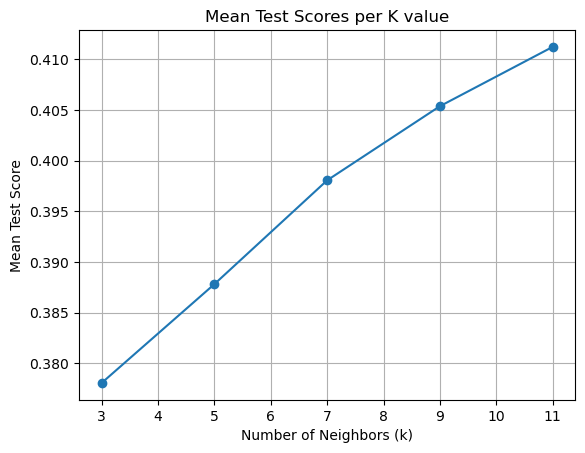

Confusion Matrix:
 [[21  8  6  2]
 [17 38 16  8]
 [ 7 18 19 14]
 [ 6 12 21 15]]


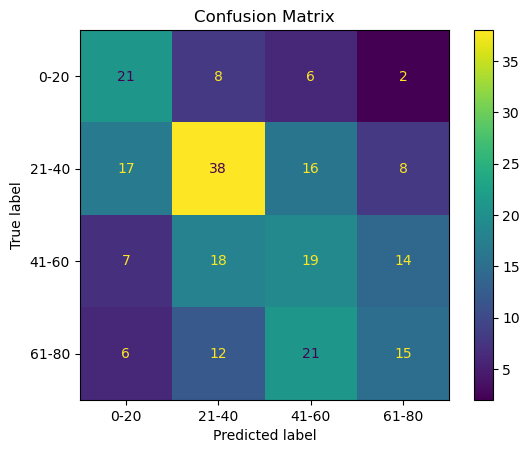

Classification Report:
               precision    recall  f1-score   support

        0-20       0.41      0.57      0.48        37
       21-40       0.50      0.48      0.49        79
       41-60       0.31      0.33      0.32        58
       61-80       0.38      0.28      0.32        54

    accuracy                           0.41       228
   macro avg       0.40      0.41      0.40       228
weighted avg       0.41      0.41      0.40       228



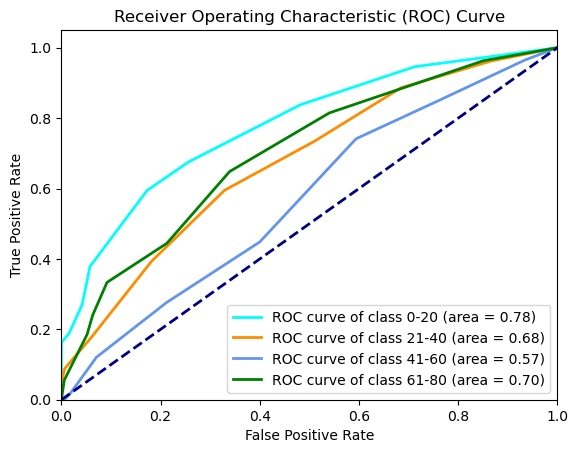

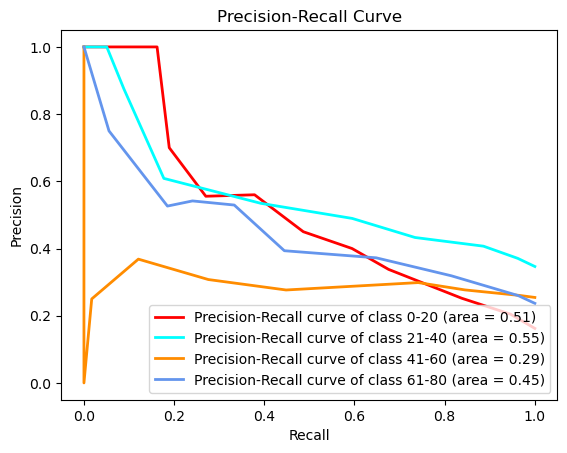

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

file_path = 'NHANES_age_prediction.csv'
df = pd.read_csv(file_path)

print(df.columns)

df = df.apply(pd.to_numeric, errors='coerce')

df.dropna(axis=1, how='all', inplace=True)

df.dropna(inplace=True)

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
df['age_group'] = pd.cut(df['RIDAGEYR'], bins=bins, labels=labels)

X = df.drop(['RIDAGEYR', 'age_group'], axis=1)
y = df['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

cv_results = grid_search.cv_results_

mean_test_scores = cv_results['mean_test_score']
plt.figure()
plt.plot(param_grid['knn__n_neighbors'], mean_test_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Scores per K value')
plt.grid()
plt.show()

y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

unique_labels = np.unique(y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

y_test_binarized = label_binarize(y_test, classes=unique_labels)
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {unique_labels[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

precision = dict()
recall = dict()
pr_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve of class {unique_labels[i]} (area = {pr_auc[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


